In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Create freq_dict, a dictionary that records the frequency at which data was taken.
features = ['Consumption_HH', 'Income_Ineq_SL', 'Active_List_UT_County', 'Med_Price_Per_SQF', 'SNAP', 
 'Med_Days_Mkt', 'Housing_Auth', 'Med_Income_SL', 'GDP', 'Population', 'Housing_Price_Index',
 'Per_Cap_Pers_Income', 'Unemp_Rate', 'Rental_Vac_Rate', 'Median_Income', 'Educ_Attain',
 'Net_Mig_Flow_UT_County', 'Percent_Single', 'Active_List_SL']
frequency = ['year', 'year', 'month', 'month', 'month', 'month', 'month', 'year',
             'quarter', 'year', 'quarter', 'year', 'month',
            'year', 'year', 'year', 'year_div', 'year', 'month']
freq_dict = dict(zip(features, frequency))
freq_dict

{'Consumption_HH': 'year',
 'Income_Ineq_SL': 'year',
 'Active_List_UT_County': 'month',
 'Med_Price_Per_SQF': 'month',
 'SNAP': 'month',
 'Med_Days_Mkt': 'month',
 'Housing_Auth': 'month',
 'Med_Income_SL': 'year',
 'GDP': 'quarter',
 'Population': 'year',
 'Housing_Price_Index': 'quarter',
 'Per_Cap_Pers_Income': 'year',
 'Unemp_Rate': 'month',
 'Rental_Vac_Rate': 'year',
 'Median_Income': 'year',
 'Educ_Attain': 'year',
 'Net_Mig_Flow_UT_County': 'year_div',
 'Percent_Single': 'year',
 'Active_List_SL': 'month'}

# Step 1: Use ARIMA to predict future behavior of features

In [3]:
def arima(data, domain, feature_name, p=4, q=4, n=30):
    """
    Build an ARIMA model with statsmodel and 
    predict future n values.

    Parameters:
        file (str): data file
        p (int): maximum order of autoregressive model
        q (int): maximum order of moving average model
        n (int): number of values to predict

    Return:
        aic (float): aic of optimal model
    """
    # Get the first difference of the data.
    Z = data.to_numpy()
    m = len(Z)
    # Find the p and q which give the best AIC.
    best_aic = np.inf
    best_p, best_q = 0, 0
    for i in range(1, p):
        for j in range(1, q):
            arima = ARIMA(Z, order=(i, 0, j), trend='c').fit(method = 'innovations_mle')
            if arima.aic < best_aic:
                best_aic = arima.aic
                best_p, best_q = i, j
    
    # Make predictions using the best model.
    arima = ARIMA(Z, order=(best_p, 0, best_q), trend='c').fit(method = 'innovations_mle')
    preds = arima.predict(start=0, end=m+n-1)
    
    # Plot the old and new data and show the plot.
    plt.plot(domain[:m], Z[:m], 'k', label='Old Data')
    plt.plot(domain, preds, 'r', label='ARIMA Model')
    plt.xlabel('Year')
    plt.ylabel('Change in ' + feature_name)
    plt.title('Statsmodel ARIMA(' + str(best_p) + ',' + str(best_q) + '). AIC: '+ str(best_aic))
    plt.legend(loc='best')
    plt.show()
    
    # Return the predictions.
    return preds

Unemp_Rate:


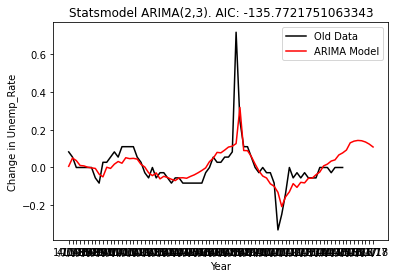

81


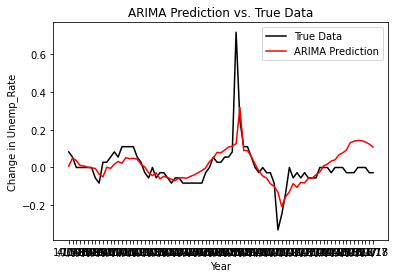

Per_Cap_Pers_Income:


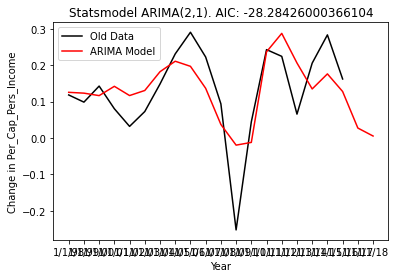

21


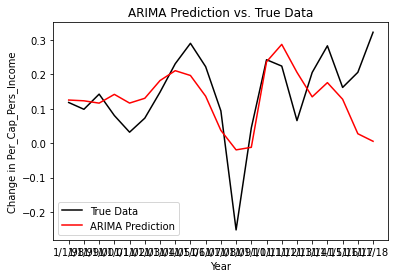

Rental_Vac_Rate:


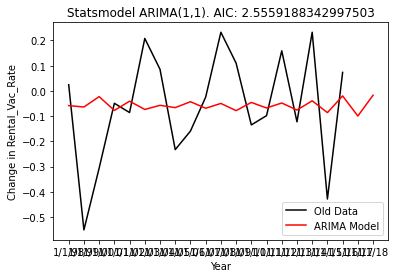

21


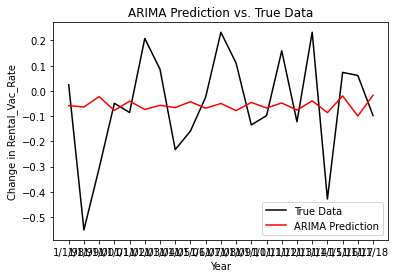

Consumption_HH:


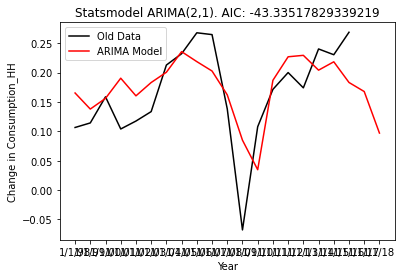

21


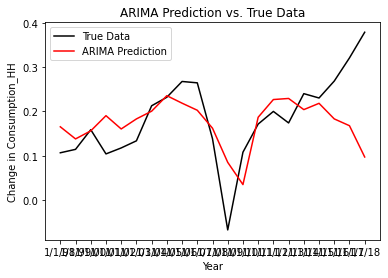

SNAP:


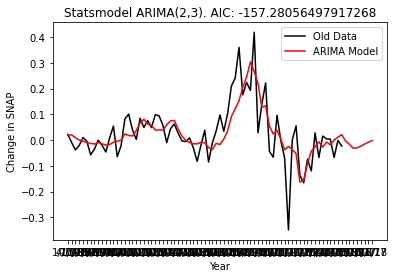

81


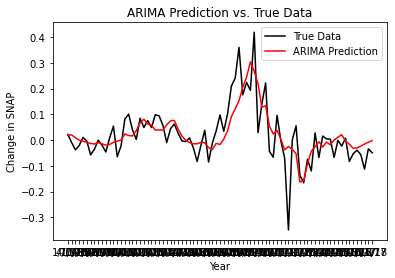

Med_Income_SL:


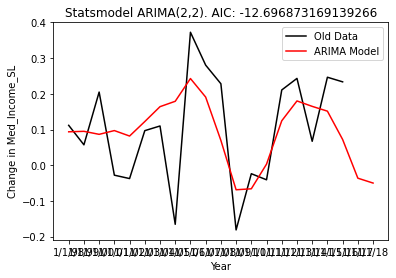

21


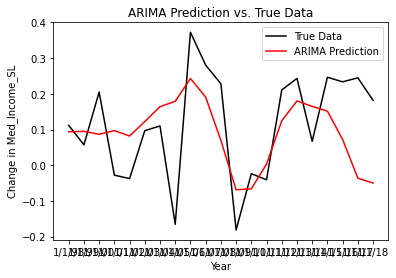

Housing_Auth:


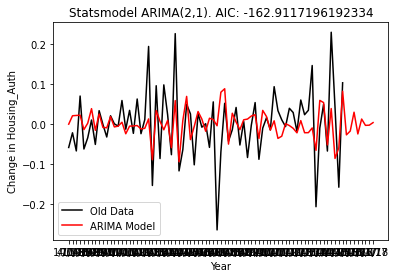

81


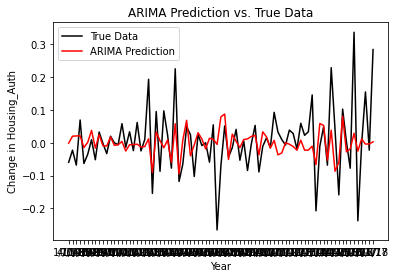

In [23]:
# Get data
df = pd.read_csv('V3_data_1997.csv', index_col='DATE')
s = pd.read_csv('Housing_Auth_Full_Quarterly.csv', index_col='DATE')
df = df.merge(s, left_index=True, right_index=True)
# Ignore 2020 as an outlier
df = df.iloc[:-4]
# Take the first forward difference of the data. We ignore the first year.
df = df.diff().iloc[4:]
# Normalize data
df = df / pd.Series([np.linalg.norm(df[df.columns[i]]) for i in range(df.shape[1])], index=df.columns)
# Separate data into train and test sets.
len_predict = 8 # Should be a multiple of 4
X_train = df.iloc[:-len_predict][df.columns.drop('Housing_Price_Index')]
y_train = df.iloc[:-len_predict]['Housing_Price_Index']
X_test = df.iloc[-len_predict:][df.columns.drop('Housing_Price_Index')]
y_test = df.iloc[-len_predict-1:]['Housing_Price_Index'] # Add an extra 1 intentionally
# Get a list of features to iterate through
features = list(df.columns.drop('Housing_Price_Index'))
pred_dict = {}
# For each feature, make an ARIMA model to predict its future behavior
for feature in features:
    if feature == 'Population':
        continue
    print(feature + ":")
    X = X_train[feature]
    if freq_dict[feature] == "year":
        every = 4
    else:
        every = 1
    X = X[::every]
    n = len_predict // every
    predictions = arima(X[:-n], X.index, feature, n=n)
    print(len(predictions))
    if freq_dict[feature] == "year": # Extrapolate predictions if we only have yearly data
        pred_dict[feature] = np.hstack([[predictions[i] for _ in range(4)] for i in range(len(X)-n, len(predictions))])
    else:
        pred_dict[feature] = predictions[-n:]
    # Plot the full dataset and the ARIMA predictions.
    plt.plot(X.index, X, 'k', label='True Data')
    plt.plot(X.index, predictions, 'r', label='ARIMA Prediction')
    plt.xlabel('Year')
    plt.ylabel('Change in ' + feature)
    plt.title('ARIMA Prediction vs. True Data')
    plt.legend(loc='best')
    plt.show()

In [24]:
# These are our ARIMA model predictions for each of these features for the next len_predict quarters.
pred_dict

{'Unemp_Rate': array([0.09250955, 0.130822  , 0.13976874, 0.14343814, 0.14185684,
        0.13524731, 0.1240135 , 0.10871997]),
 'Per_Cap_Pers_Income': array([0.02754606, 0.02754606, 0.02754606, 0.02754606, 0.0056232 ,
        0.0056232 , 0.0056232 , 0.0056232 ]),
 'Rental_Vac_Rate': array([-0.0994374, -0.0994374, -0.0994374, -0.0994374, -0.0169609,
        -0.0169609, -0.0169609, -0.0169609]),
 'Consumption_HH': array([0.16781601, 0.16781601, 0.16781601, 0.16781601, 0.09705753,
        0.09705753, 0.09705753, 0.09705753]),
 'SNAP': array([-0.0038449 , -0.01561994, -0.03175056, -0.03051346, -0.0234748 ,
        -0.0153904 , -0.00803538, -0.00192151]),
 'Med_Income_SL': array([-0.03624635, -0.03624635, -0.03624635, -0.03624635, -0.04991525,
        -0.04991525, -0.04991525, -0.04991525]),
 'Housing_Auth': array([-0.02763232, -0.01810731,  0.0289819 , -0.02540804,  0.01187403,
        -0.00395935, -0.00347085,  0.00296972])}

# Step 2: Use RandomForests based on predicted values

In [26]:
rfr = RandomForestRegressor()
idx = df.index
for feature in features:
    if feature == 'Population':
        continue
    # Override actual test values with our ARIMA predicted values
    X_test[feature] = pred_dict[feature]
# Fit the Random Forest and predict new values
rfr.fit(X_train, y_train)
predictions = rfr.predict(X_test)
# Give us a score on how we did at predicting values
rfr.score(X_test, y_test[1:])

-6.987643113314775

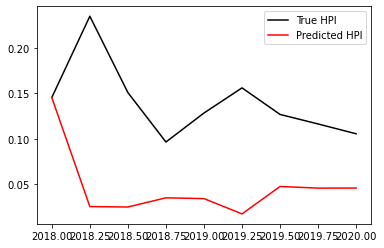

In [29]:
dates = np.linspace(2018, 2020, len_predict+1)
plt.plot(dates, y_test, 'k', label="True HPI")
original_predicted_hpi = y_test.copy()
original_predicted_hpi[-len_predict:] = predictions
plt.plot(dates, original_predicted_hpi, 'r', label="Predicted HPI")
plt.legend()
plt.show()

# Step 3: Edit predicted values to force a certain behavior

In [52]:
rfr = RandomForestRegressor()
for feature in features:
    if feature == 'Population':
        continue
    # Override actual test values with our ARIMA predicted values
    X_test[feature] = pred_dict[feature]
# Ignore the ARIMA predicted values for our chosen feature, and override it.
changed_feature = 'Housing_Auth'
X_test[changed_feature] = 10*np.ones_like(X_test[changed_feature])
# Fit the Random Forest and predict new values
rfr.fit(X_train, y_train)
predictions = rfr.predict(X_test)
# Give us a score on how we did at predicting values
rfr.score(X_test, y_test[1:])

-5.937948465808474

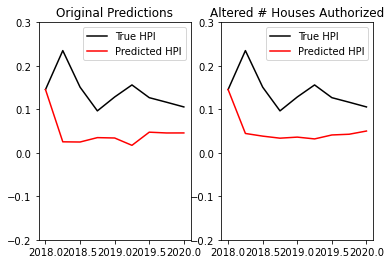

In [53]:
plt.subplot(121)
plt.ylim(-0.2,0.3)
plt.title("Original Predictions")
plt.plot(dates, y_test, 'k', label="True HPI")
plt.plot(dates, original_predicted_hpi, 'r', label="Predicted HPI")
plt.legend()
plt.subplot(122)
plt.ylim(-0.2,0.3)
plt.title("Altered # Houses Authorized")
plt.plot(dates, y_test, 'k', label="True HPI")
altered_predicted_hpi = y_test.copy()
altered_predicted_hpi[-len_predict:] = predictions
plt.plot(dates, altered_predicted_hpi, 'r', label="Predicted HPI")
plt.legend()
plt.show()

### Feature Importances

In [17]:
list(zip(X_test.columns[np.argsort(rfr.feature_importances_)], np.sort(rfr.feature_importances_)))

[('Rental_Vac_Rate', 0.012690819821966993),
 ('Per_Cap_Pers_Income', 0.013385144938053237),
 ('Med_Income_SL', 0.01395965263619979),
 ('Population', 0.015439037061441032),
 ('Consumption_HH', 0.03623990136363524),
 ('Housing_Auth', 0.1367992073147079),
 ('Unemp_Rate', 0.1369433761088429),
 ('SNAP', 0.634542860755153)]